# Initialization

## Imports

In [1]:
import math
import zipfile
import pandas as pd
import numpy as np
import random
import os
import datetime
import tensorflow as tf
import time
import seaborn as sns
from enum import Enum
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GroupShuffleSplit
from keras import backend as K
from tensorflow import reduce_mean
from tensorflow.keras.layers import Embedding, Dense, Reshape, ReLU, BatchNormalization, Concatenate, Add, Softmax
from tensorflow.keras import Input
from tensorflow.keras.activations import softmax, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.math import l2_normalize, pow, sqrt
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Seed and Session

In [2]:
# set seeds
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)

In [3]:
#tensorflow` session:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Data

## Data Preprocess

In [4]:
def get_genres(row):
    genres = []
    for i,(genre,v) in enumerate(row.items(), start=1): # Start at 1, since we pad later on
        if v == 1:
            genres.append(i)
    return genres

def normalize_col(df,col_name):
    df[col_name] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return df

In [5]:
# data
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'u.user', sep='|', names=users_cols, encoding='latin-1')

users = normalize_col(users,'age')

users.loc[users['sex'] == 'M', 'sex'] = 0
users.loc[users['sex'] == 'F', 'sex'] = 1

watch_cols = ['user_id', 'movie_id', 'rating', 'watch_hist_time']
watches = pd.read_csv(
    'u.data', sep='\t', names=watch_cols, encoding='latin-1')

watches['rating_norm'] = watches['rating']
watches = normalize_col(watches,'rating_norm')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western",
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'u.item', sep='|', names=movies_cols, encoding='latin-1')

# movie_id 267 is empty
movies = movies[movies['movie_id'] != 267]
movies = movies.reset_index(drop=True)
movies['movie_id'] = movies.index

watches = watches[watches['movie_id'] != 267]

movies['movie_age'] = (pd.to_datetime("now") - pd.to_datetime(movies['release_date']))\
            /np.timedelta64(1,'D') 

movies['movie_age_sq'] = movies['movie_age'].apply(lambda x: np.power(x, 2))
watches['watch_hist_time_sq'] = watches['watch_hist_time'].apply(lambda x: np.power(x, 2))

movies = normalize_col(movies,'movie_age')
watches = normalize_col(watches,'watch_hist_time')

movies = normalize_col(movies,'movie_age_sq')
watches = normalize_col(watches,'watch_hist_time_sq')

movies['movie_age_sqrt'] = movies['movie_age'].apply(lambda x: np.sqrt(x))

movies['genres'] = movies.loc[:,'genre_unknown':'Western'].apply(get_genres, axis=1)

# data merge
data = watches.merge(movies, on='movie_id').merge(users, on='user_id')
data['user_id']=data['user_id'].astype(int)
data['movie_id']=data['movie_id'].astype(int)
data = data.set_index(['user_id']).sort_index()
data = data.reset_index()

# occupation encoding
occupations = data["occupation"].unique().tolist()
occupations_encoded = {x: i for i, x in enumerate(occupations)}
occupationsencoded2occupations = {i: x for i, x in enumerate(occupations)}

# zip_code encoding
zip_code = data["zip_code"].unique().tolist()
zip_code_encoded = {x: i for i, x in enumerate(zip_code)}
zip_codeencoded2zip_code = {i: x for i, x in enumerate(zip_code)}

# apply encodings
data["occupation"] = data["occupation"].map(occupations_encoded)
data["zip_code"] = data["zip_code"].map(zip_code_encoded)

data = data.sort_values(['user_id','watch_hist_time'])

watch_hist = data.groupby(['user_id'])['movie_id'].apply(list).reset_index()
user_ratings = data.groupby(['user_id'])['rating'].apply(list).reset_index()
user_ratings_norm = data.groupby(['user_id'])['rating_norm'].apply(list).reset_index()
watch_hist_time = data.groupby(['user_id'])['watch_hist_time'].apply(list).reset_index()
watch_hist_time_sq = data.groupby(['user_id'])['watch_hist_time_sq'].apply(list).reset_index()
movie_age = data.groupby(['user_id'])['movie_age'].apply(list).reset_index()
movie_age_sq = data.groupby(['user_id'])['movie_age_sq'].apply(list).reset_index()
genres = data.groupby(['user_id'])['genres'].apply(list).reset_index()

sample_data = data[['user_id','age','occupation','sex','zip_code']]
sample_data = sample_data.drop_duplicates()

user_movie_list = pd.merge(sample_data,watch_hist, how= 'left')
user_movie_list = pd.merge(user_movie_list,user_ratings, how='left')
user_movie_list = pd.merge(user_movie_list,user_ratings_norm, how='left')
user_movie_list = pd.merge(user_movie_list,watch_hist_time, how='left')
user_movie_list = pd.merge(user_movie_list,watch_hist_time_sq, how='left')
user_movie_list = pd.merge(user_movie_list,movie_age, how='left')
user_movie_list = pd.merge(user_movie_list,movie_age_sq, how='left')
user_movie_list = pd.merge(user_movie_list,genres, how='left')

## Dataframes Overview

In [6]:
movies.head(1)

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_age,movie_age_sq,movie_age_sqrt,genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0.049583,0.02075,0.222672,"[4, 5, 6]"


In [7]:
users.head(1)

,user_id,age,sex,occupation,zip_code
0,1,0.257576,0,technician,85711


In [8]:
watches.head(1)

,user_id,movie_id,rating,watch_hist_time,rating_norm,watch_hist_time_sq
0,196,242,3,0.351593,0.5,0.349199


In [9]:
data.head(1)

,user_id,movie_id,rating,watch_hist_time,rating_norm,watch_hist_time_sq,title,release_date,video_release_date,imdb_url,...,War,Western,movie_age,movie_age_sq,movie_age_sqrt,genres,age,sex,occupation,zip_code
41,1,168,5,0.012971,1.0,0.012837,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,...,0,0,0.075604,0.032844,0.274962,"[4, 6]",0.257576,0,0,0


## Split data into Train,Test and Windows

(for convenience, we've saved the splitted data as a parquet, thus we can just load it quickly from the gzip file)

In [10]:
# def get_windows(data, win_size=20):
#     df = pd.DataFrame(columns=data.columns.to_list() + ['example_age', 'label_genres', 'label_age', 'label_age_sq', 'label', 'label_score'])
    
#     n = 0
#     for i, row in tqdm(data.iterrows(), total=data.shape[0]):
#         user_movie_n = len(row.movie_id)
#         for j in range(user_movie_n):
#             if not user_movie_n - j < win_size:
#                 new_row = row.copy()
#                 new_row['movie_id':] = new_row['movie_id':].transform(lambda x: x[j:j+win_size-1])
#                 df.at[n,:] = new_row
#                 df.at[n,'genres'] = list(set([item for sublist in new_row['genres'] for item in sublist]))
#                 df.at[n,'example_age'] = new_row['watch_hist_time'][-1]
#                 df.at[n,'label_genres'] = new_row['genres'][-1]
#                 df.at[n,'label_age'] = new_row['movie_age'][-1]
#                 df.at[n,'label_age_sq'] = new_row['movie_age_sq'][-1]
#                 df.at[n,'label'] = new_row['movie_id'][-1]
#                 df.at[n,'label_score'] = new_row['rating_norm'][-1]
#                 n += 1
#     return df


In [11]:
# from sklearn.model_selection import train_test_split

# X_train, X_test = train_test_split(user_movie_list, test_size=0.2, random_state=SEED)

In [12]:
# WIN_SIZE = 20

In [13]:
# X_train = get_windows(X_train, win_size=WIN_SIZE)

In [14]:
# X_test = get_windows(X_test, win_size=WIN_SIZE)

In [15]:
# X_train.to_parquet('train_win_20.parquet.gzip', compression='gzip')
# X_test.to_parquet('test_win_20.parquet.gzip', compression='gzip')

## Load Data

In [16]:
X_train = pd.read_parquet('train_win_20.parquet.gzip')
X_test = pd.read_parquet('test_win_20.parquet.gzip')

In [17]:
X_train.head(1)

,user_id,age,occupation,sex,zip_code,movie_id,rating,rating_norm,watch_hist_time,watch_hist_time_sq,movie_age,movie_age_sq,genres,example_age,label_genres,label_age,label_age_sq,label,label_score
0,245,0.227273,5,0,230,"[210, 300, 133, 94, 222, 151, 597, 473, 596, 1...","[3, 4, 2, 2, 4, 3, 4, 2, 4, 3, 3, 3, 5, 4, 3, ...","[0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25,...","[0.7428277924577662, 0.7428277924577662, 0.742...","[0.7408221652495353, 0.7408221652495353, 0.740...","[0.3750623796962999, 0.023526056890283024, 0.7...","[0.23162165631679885, 0.00946745624803864, 0.6...","[2, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17,...",0.742862,"[8, 14, 17, 18]",0.062594,0.026686,50,0.75


In [18]:
X_test.head(1)

,user_id,age,occupation,sex,zip_code,movie_id,rating,rating_norm,watch_hist_time,watch_hist_time_sq,movie_age,movie_age_sq,genres,example_age,label_genres,label_age,label_age_sq,label,label_score
0,97,0.545455,13,0,91,"[408, 135, 168, 430, 482, 132, 496, 173, 98, 4...","[5, 5, 4, 5, 5, 5, 2, 3, 4, 4, 5, 2, 1, 5, 1, ...","[1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.25, 0.5, 0.7...","[0.5125513901357661, 0.5125513901357661, 0.512...","[0.5099283539163012, 0.5099283539163012, 0.509...","[0.029692735438796608, 0.7786768375276253, 0.0...","[0.012061133019070148, 0.6732098803989792, 0.0...","[2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, ...",0.51256,"[1, 5, 17]",0.075604,0.032834,79,1.0


## Split Train and Val

In [19]:
splitter = GroupShuffleSplit(test_size=.2, n_splits=1, random_state=SEED)
split = splitter.split(X_train, groups=X_train['user_id'])

split_idx = list(split)[0]
train_idx = split_idx[0]
val_idx = split_idx[1]

# Models

## Define Model Types

In [20]:
class MODEL(Enum):
    WIDE = 1
    DEEP = 2
    WIDE_AND_DEEP = 3

## Define Hyperparameters

In [21]:
FEATURES_EMBEDDING_DIMS = 512
OCCUPATIONS_EMBEDDING_DIMS = 8
ZIP_EMBEDDING_DIMS = 256
GENRES_EMBEDDING_DIMS = 8

DENSE_UNITS = 64
NUM_CLASSES = data["movie_id"].max() + 1
NUM_OCC = data["occupation"].max() + 1
NUM_ZIP = data["zip_code"].max() + 1
NUM_GENRES = 19 + 1

LEARNING_RATE = 0.001
BATCH_SIZE = 256

# Candidate Model

## Define Candidate Model

In [22]:
def get_candidate_model(MODEL_TYPE=MODEL.WIDE, FEATURES_EMBEDDING_DIMS=512, DENSE_UNITS=256,
                        LEARNING_RATE=0.001, LOSS='sparse_categorical_crossentropy'):

    #---inputs
    input_watch_hist =          Input(shape=(19,), name='watch_hist')
    input_watch_hist_time =     Input(shape=(19,), name='watch_hist_time')
    input_watch_hist_time_sq =  Input(shape=(19,), name='watch_hist_time_sq')
    input_movie_age =           Input(shape=(19,), name='movie_age')
    input_movie_age_sq =        Input(shape=(19,), name='movie_age_sq')
    input_rating_norm =         Input(shape=(19,), name='rating_norm')
    input_genres =              Input(shape=(None,), name='genres')
    input_example_age =         Input(shape=(1,), name='example_age')
    input_age =                 Input(shape=(1,), name='age')
    input_occupation =          Input(shape=(1,), name='occupation')
    input_zip =                 Input(shape=(1,), name='zip')
    input_gender =              Input(shape=(2,), name='gender')


    #--- layers
    features_embedding_layer = Embedding(input_dim=NUM_CLASSES, output_dim=FEATURES_EMBEDDING_DIMS, 
                                         trainable=True, name='features_embeddings')
    occupation_embedding_layer = Embedding(input_dim=NUM_OCC, output_dim=OCCUPATIONS_EMBEDDING_DIMS, 
                                           trainable=True, name='occupation_embeddings')
    zip_embedding_layer = Embedding(input_dim=NUM_ZIP, output_dim=ZIP_EMBEDDING_DIMS, 
                                    trainable=True, name='zip_embeddings')
    genres_embedding_layer = Embedding(input_dim=NUM_GENRES, output_dim=GENRES_EMBEDDING_DIMS, 
                                       mask_zero=True, trainable=True, name='genres_embeddings')

    dense_1 = Dense(units=DENSE_UNITS*4, name='dense_1')
    dense_2 = Dense(units=DENSE_UNITS*2, name='dense_2')
    dense_3 = Dense(units=DENSE_UNITS, name='dense_3')

    dense_wide = Dense(units=DENSE_UNITS, name='dense_wide')

    dense_output = Dense(NUM_CLASSES, name='dense_output')

    #--- features
    features_embeddings = features_embedding_layer(input_watch_hist)
    l2_norm_features = l2_normalize(features_embeddings, axis=-1)
    avg_features = reduce_mean(l2_norm_features, axis=1)

    occupation_embeddings = occupation_embedding_layer(input_occupation)
    l2_norm_occupation = l2_normalize(occupation_embeddings, axis=-1)

    zip_embeddings = zip_embedding_layer(input_zip)
    l2_norm_zip = l2_normalize(zip_embeddings, axis=-1)

    genres_embeddings = genres_embedding_layer(input_genres)
    l2_norm_genres = l2_normalize(genres_embeddings, axis=-1)
    avg_genres = reduce_mean(l2_norm_genres, axis=1)

    avg_features = Reshape((FEATURES_EMBEDDING_DIMS,), name='avg_features_reshape')(avg_features)
    l2_norm_occupation = Reshape((OCCUPATIONS_EMBEDDING_DIMS,), name='l2_norm_occupation_reshape')(l2_norm_occupation)
    l2_norm_zip = Reshape((ZIP_EMBEDDING_DIMS,), name='l2_norm_zip_reshape')(l2_norm_zip)
    avg_genres = Reshape((GENRES_EMBEDDING_DIMS,), name='avg_genres_reshape')(avg_genres)

    concat_inputs = Concatenate(axis=-1)([avg_features,
                                        input_watch_hist_time,
                                        # input_watch_hist_time_sq,
                                        input_movie_age,
                                        # input_movie_age_sq,
                                        input_rating_norm,
                                        avg_genres,
                                        input_example_age,
                                        input_age,
                                        l2_norm_occupation,
                                        l2_norm_zip,
                                        input_gender,
                                        ])
    
    if MODEL_TYPE == MODEL.WIDE:
        dense_wide_features = dense_wide(concat_inputs)
        dense_3_relu = ReLU(name='dense_3_relu')(dense_wide_features)

    else:
        # Dense Layers
        dense_1_features = dense_1(concat_inputs)
        dense_1_relu = ReLU(name='dense_1_relu')(dense_1_features)
        dense_1_batch_norm = BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)
        
        dense_2_features = dense_2(dense_1_relu)
        dense_2_relu = ReLU(name='dense_2_relu')(dense_2_features)
        dense_2_batch_norm = BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

        dense_3_features = dense_3(dense_2_relu)

        if MODEL_TYPE == MODEL.DEEP:
            dense_3_relu = ReLU(name='dense_3_relu')(dense_3_features)

        elif MODEL_TYPE == MODEL.WIDE_AND_DEEP:
            dense_wide_features = dense_wide(concat_inputs)
            dense_3_wide_features = Add()([dense_3_features, dense_wide_features])
            dense_3_relu = ReLU(name='dense_3_relu')(dense_3_wide_features)

    dense_outputs = dense_output(dense_3_relu)
    outputs = Softmax(name='softmax_output')(dense_outputs)

    #Optimizer
    optimiser = Adam(learning_rate=LEARNING_RATE)

    #--- prep model
    model = Model(
        inputs=[input_watch_hist, 
                input_watch_hist_time, 
                input_watch_hist_time_sq,
                input_movie_age,
                input_movie_age_sq,
                input_rating_norm,
                input_genres,
                input_example_age,
                input_age,
                input_occupation,
                input_zip,
                input_gender
                ],
        outputs=[outputs]
    )
    
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy',
                  metrics=[SparseTopKCategoricalAccuracy(k=5, name='top5_acc'),
                           SparseTopKCategoricalAccuracy(k=10, name='top10_acc')])

    serving_model = Model(inputs=model.input,
                          outputs=[model.get_layer('dense_3_relu').output,
                                   model.get_layer('softmax_output').output])

    return model, serving_model

## Get Candidate Data

In [23]:
def get_candidate_model_X_y(df):
    X = [pad_sequences(df['movie_id']),
         pad_sequences(df['watch_hist_time'], dtype=float),
         pad_sequences(df['watch_hist_time_sq'], dtype=float),
         pad_sequences(df['movie_age'], dtype=float),
         pad_sequences(df['movie_age_sq'], dtype=float),
         pad_sequences(df['rating_norm'], dtype=float),
         pad_sequences(df['genres']),
         pad_sequences(df['example_age'].to_numpy().reshape(-1,1), dtype=float),
         pad_sequences(df['age'].to_numpy().reshape(-1,1), dtype=float),
         pad_sequences(df['occupation'].to_numpy().reshape(-1,1)),
         pad_sequences(df['zip_code'].to_numpy().reshape(-1,1)),
         pad_sequences(pd.get_dummies(df['sex']).values)]

    if df.sex.nunique() == 1:
      if df.sex.unique()[0] == 0:
          X[11] = np.concatenate([np.zeros(X[11].shape, dtype='int32'), X[11]],axis=1)
      else:
          X[11] = np.concatenate([X[11],np.zeros(X[11].shape, dtype='int32')],axis=1)

    y = pad_sequences(df['label'].to_numpy().reshape(-1,1))
    return X,y

def get_candidate_model_data(df):
    X, y = get_candidate_model_X_y(df)
    return X, y    

## Train Candidate Model

In [24]:
def candidate_model_train(model_type):
    LOSS = 'sparse_categorical_crossentropy'
    EPOCH = 15

    logdir_candidate = os.path.join("logs/candidate", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback_candidate = TensorBoard(logdir_candidate, histogram_freq=1)

    learning_rate_params = [0.001, 0.01]
    dense_units_params = [128, 256]
    feature_embeddings_dims_params = [512]

    candidate_results_df = pd.DataFrame(columns=['learning_rate','dense_units','feature_embeddings_dims', 'val_loss', 'val_top5_acc', 'val_top10_acc', 'loss', 'top5_acc', 'top10_acc' ,'Time', 'History', 'candidate_model', 'serving_candidate_model'])
    candidate_results = []

    i = 0
    for lr in learning_rate_params:
        for dense_units in dense_units_params:
            for embed_dims in feature_embeddings_dims_params:
                i+=1

                print(f'\n\n### Experiment Num {i}: ###\n\n')
                print(f'learning_rate:{lr}, dense_units:{dense_units}, feature_embeddings_dims:{embed_dims}\n')

                dic = {'learning_rate':lr, 'dense_units':dense_units, 'feature_embeddings_dims':embed_dims}

                # initialize model
                candidate_model, serving_candidate_model = get_candidate_model(MODEL_TYPE=model_type, FEATURES_EMBEDDING_DIMS=embed_dims,
                                                            DENSE_UNITS=dense_units, LEARNING_RATE=lr, LOSS=LOSS)
                
                # record training time
                start = time.time()
                
                # train model
                candidate_history = candidate_model.fit(X_train_candidate, y_train_candidate,
                                  validation_data=(X_val_candidate, y_val_candidate),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCH,
                                  callbacks=[tensorboard_callback_candidate])

                # record traning time
                dic['Time'] = time.time() - start
            
                # record model history
                dic['val_loss'] = round(candidate_history.history['val_loss'][-1],3)
                dic['val_top5_acc'] = round(candidate_history.history['val_top5_acc'][-1],3)
                dic['val_top10_acc'] = round(candidate_history.history['val_top10_acc'][-1],3)
                dic['loss'] = candidate_history.history['loss']
                dic['top5_acc'] = candidate_history.history['top5_acc']
                dic['top10_acc'] = candidate_history.history['top10_acc']

                # record model
                dic['candidate_model'] = candidate_model
                dic['serving_candidate_model'] = serving_candidate_model

                # record model history
                dic['History'] = candidate_model.history
                
                # add experiment
                candidate_results.append(dic)
                candidate_results_df = candidate_results_df.append(dic,ignore_index=True)

    return candidate_results_df, candidate_results

##Plot Training Loss and Accuracy

In [25]:
def candidate_plot(metric):
    plt.figure(figsize=(16,6))
    lines = candidate_results_df[metric]
    for l in lines:
        plt.plot(l)

    plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
    plt.title(f'training {metric} history')
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.show()

In [26]:
def candidate_plot_top3(metric):
    plt.figure(figsize=(16,6))
    lines = candidate_results_df[metric]
    lines = lines[candidate_results_df.val_top10_acc.nlargest(3).index]
    
    for l in lines:
        plt.plot(l)

    leg = (candidate_results_df.loc[candidate_results_df.val_top10_acc.nlargest(3).index,['learning_rate','dense_units','feature_embeddings_dims']]).T.to_dict().values()
    plt.title(f'training top3 {metric} history')
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.legend(leg)
    plt.show();

# Ranking Model

## Define Ranking Model

In [27]:
def get_ranking_model(MODEL_TYPE=MODEL.WIDE, FEATURES_EMBEDDING_DIMS=512, DENSE_UNITS=256,
                      LEARNING_RATE=0.001, LOSS='mse'):

    #---inputs
    input_watch_hist =          Input(shape=(19,), name='watch_hist')
    input_watch_hist_time =     Input(shape=(19,), name='watch_hist_time')
    input_watch_hist_time_sq =  Input(shape=(19,), name='watch_hist_time_sq')
    input_movie_age =           Input(shape=(19,), name='movie_age')
    input_movie_age_sq =        Input(shape=(19,), name='movie_age_sq')
    input_rating_norm =         Input(shape=(19,), name='rating_norm')
    input_genres =              Input(shape=(None,), name='genres')
    input_example_age =         Input(shape=(1,), name='example_age')
    input_age =                 Input(shape=(1,), name='age')
    input_occupation =          Input(shape=(1,), name='occupation')
    input_zip =                 Input(shape=(1,), name='zip')
    input_gender =              Input(shape=(2,), name='gender')

    input_candidate =           Input(shape=(1,), name='candidate')
    input_candidate_age =       Input(shape=(1,), name='candidate_age')
    input_candidate_age_sq =    Input(shape=(1,), name='candidate_age_sq')
    input_candidate_genres =    Input(shape=(None,), name='candidate_genres')

    #--- layers
    features_embedding_layer = Embedding(input_dim=NUM_CLASSES, output_dim=FEATURES_EMBEDDING_DIMS, 
                                        trainable=True, name='features_embeddings')
    occupation_embedding_layer = Embedding(input_dim=NUM_OCC, output_dim=OCCUPATIONS_EMBEDDING_DIMS, 
                                        trainable=True, name='occupation_embeddings')
    zip_embedding_layer = Embedding(input_dim=NUM_ZIP, output_dim=ZIP_EMBEDDING_DIMS, 
                                    trainable=True, name='zip_embeddings')
    genres_embedding_layer = Embedding(input_dim=NUM_GENRES, output_dim=GENRES_EMBEDDING_DIMS, 
                                    mask_zero=True, trainable=True, name='genres_embeddings')


    dense_1 = Dense(units=DENSE_UNITS*4, name='dense_1')
    dense_2 = Dense(units=DENSE_UNITS*2, name='dense_2')
    dense_3 = Dense(units=DENSE_UNITS, name='dense_3')

    dense_wide = Dense(units=DENSE_UNITS, name='dense_wide')

    dense_output = Dense(1, name='dense_output')

    #--- features
    features_embeddings = features_embedding_layer(input_watch_hist)
    l2_norm_features = l2_normalize(features_embeddings, axis=-1)
    avg_features = reduce_mean(l2_norm_features, axis=1)

    occupation_embeddings = occupation_embedding_layer(input_occupation)
    l2_norm_occupation = l2_normalize(occupation_embeddings, axis=-1)

    zip_embeddings = zip_embedding_layer(input_zip)
    l2_norm_zip = l2_normalize(zip_embeddings, axis=-1)

    genres_embeddings = genres_embedding_layer(input_genres)
    l2_norm_genres = l2_normalize(genres_embeddings, axis=-1)
    avg_genres = reduce_mean(l2_norm_genres, axis=1)

    candidate_embeddings = features_embedding_layer(input_candidate)
    l2_norm_candidate = l2_normalize(candidate_embeddings, axis=-1)

    candidate_genres_embeddings = genres_embedding_layer(input_candidate_genres)
    l2_norm_candidate_genres = l2_normalize(candidate_genres_embeddings, axis=-1)
    avg_candidate_genres = reduce_mean(l2_norm_candidate_genres, axis=1)

    avg_features = Reshape((FEATURES_EMBEDDING_DIMS,))(avg_features)
    l2_norm_candidate = Reshape((FEATURES_EMBEDDING_DIMS,))(l2_norm_candidate)
    l2_norm_occupation = Reshape((OCCUPATIONS_EMBEDDING_DIMS,))(l2_norm_occupation)
    l2_norm_zip = Reshape((ZIP_EMBEDDING_DIMS,))(l2_norm_zip)
    avg_genres = Reshape((GENRES_EMBEDDING_DIMS,))(avg_genres)
    avg_candidate_genres = Reshape((GENRES_EMBEDDING_DIMS,))(avg_candidate_genres)

    concat_inputs = Concatenate(axis=-1)([l2_norm_candidate,
                                        avg_candidate_genres,
                                        input_candidate_age,
                                        input_candidate_age_sq,
                                        avg_features,
                                        input_watch_hist_time,
                                        input_watch_hist_time_sq,
                                        input_movie_age,
                                        input_movie_age_sq,
                                        input_rating_norm,
                                        avg_genres,
                                        input_example_age,
                                        sqrt(input_example_age),
                                        pow(input_example_age, 2),
                                        input_age,
                                        l2_norm_occupation,
                                        l2_norm_zip,
                                        input_gender,
                                        ])
    # Dense Layers
    if MODEL_TYPE == MODEL.WIDE:
        dense_wide_features = dense_wide(concat_inputs)
        dense_3_relu = ReLU(name='dense_3_relu')(dense_wide_features)

    else:
        # Dense Layers
        dense_1_features = dense_1(concat_inputs)
        dense_1_relu = ReLU(name='dense_1_relu')(dense_1_features)
        dense_1_batch_norm = BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)
        
        dense_2_features = dense_2(dense_1_relu)
        dense_2_relu = ReLU(name='dense_2_relu')(dense_2_features)
        dense_2_batch_norm = BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

        dense_3_features = dense_3(dense_2_relu)

        if MODEL_TYPE == MODEL.DEEP:
            dense_3_relu = ReLU(name='dense_3_relu')(dense_3_features)

        elif MODEL_TYPE == MODEL.WIDE_AND_DEEP:
            dense_wide_features = dense_wide(concat_inputs)
            dense_3_wide_features = Add()([dense_3_features, dense_wide_features])
            dense_3_relu = ReLU(name='dense_3_relu')(dense_3_wide_features)

    dense_outputs = dense_output(dense_3_relu)
    outputs = sigmoid(dense_outputs)

    #Optimizer
    optimiser = Adam(learning_rate=LEARNING_RATE)

    #--- prep model
    model = Model(
        inputs=[input_watch_hist, 
                input_watch_hist_time, 
                input_watch_hist_time_sq,
                input_movie_age,
                input_movie_age_sq,
                input_rating_norm,
                input_genres,
                input_example_age,
                input_age,
                input_occupation,
                input_zip,
                input_gender,
                input_candidate,
                input_candidate_age,
                input_candidate_age_sq,
                input_candidate_genres
                ],
        outputs=[outputs]
    )

    model.compile(optimizer=optimiser, loss=LOSS)
    
    serving_model = Model(inputs=model.input,
                          outputs=model.get_layer('dense_output').output)

    return model, serving_model

## Get Ranking Data

In [28]:
def get_ranking_model_X_y(df):
    X = [pad_sequences(df['movie_id']),
         pad_sequences(df['watch_hist_time'], dtype=float),
         pad_sequences(df['watch_hist_time_sq'], dtype=float),
         pad_sequences(df['movie_age'], dtype=float),
         pad_sequences(df['movie_age_sq'], dtype=float),
         pad_sequences(df['rating_norm'], dtype=float),
         pad_sequences(df['genres']),
         pad_sequences(df['example_age'].to_numpy().reshape(-1,1), dtype=float),
         pad_sequences(df['age'].to_numpy().reshape(-1,1), dtype=float),
         pad_sequences(df['occupation'].to_numpy().reshape(-1,1)),
         pad_sequences(df['zip_code'].to_numpy().reshape(-1,1)),
         pad_sequences(pd.get_dummies(df['sex']).values),
         pad_sequences(df['label'].to_numpy().reshape(-1,1)),
         pad_sequences(df['label_age'].to_numpy().reshape(-1,1), dtype=float),
         pad_sequences(df['label_age_sq'].to_numpy().reshape(-1,1), dtype=float),
         pad_sequences(df['label_genres'])]


    if df.sex.nunique() == 1:
      if df.sex.unique()[0] == 0:
        X[11] = np.concatenate([np.zeros(X[11].shape, dtype='int32'), X[11]],axis=1)
      else:
          X[11] = np.concatenate([X[11],np.zeros(X[11].shape, dtype='int32')],axis=1)
    
    y = pad_sequences(df['label_score'].to_numpy().reshape(-1,1), dtype=float)
    return X,y

    return
def get_ranking_model_data(df):
    X, y = get_ranking_model_X_y(df)
    return X, y    

## Train Ranking Model

In [29]:
def ranking_model_train(model_type):
    LOSS = 'mse'
    EPOCH = 3

    logdir_ranking = os.path.join("logs/ranking", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback_ranking = TensorBoard(logdir_ranking, histogram_freq=1)

    learning_rate_params = [0.001, 0.01]
    dense_units_params = [128, 256]
    feature_embeddings_dims_params = [512]

    ranking_results_df = pd.DataFrame(columns=['learning_rate','dense_units','feature_embeddings_dims', 'val_loss', 'loss', 'Time', 'History', 'ranking_model', 'serving_ranking_model'])
    ranking_results = []

    i = 0
    for lr in learning_rate_params:
        for dense_units in dense_units_params:
            for embed_dims in feature_embeddings_dims_params:
                i+=1

                print(f'\n\n### Experiment Num {i}: ###\n\n')
                print(f'learning_rate:{lr}, dense_units:{dense_units}, feature_embeddings_dims:{embed_dims}\n')

                ranking_dic = {'learning_rate':lr, 'dense_units':dense_units, 'feature_embeddings_dims':embed_dims}

                # initialize model
                ranking_model, serving_ranking_model = get_ranking_model(MODEL_TYPE=model_type, FEATURES_EMBEDDING_DIMS=embed_dims,
                                                            DENSE_UNITS=dense_units, LEARNING_RATE=lr, LOSS=LOSS)
                
                # record training time
                start = time.time()
                
                # train model
                ranking_history = ranking_model.fit(X_train_ranking, y_train_ranking,
                                                    validation_data=(X_val_ranking, y_val_ranking),
                                                    batch_size=BATCH_SIZE,
                                                    epochs=EPOCH,
                                                    callbacks=[tensorboard_callback_ranking])

                # record traning time
                ranking_dic['Time'] = time.time() - start
            
                # record model history
                ranking_dic['val_loss'] = ranking_history.history['val_loss'][-1]
                ranking_dic['loss'] = ranking_history.history['loss']

                # record model
                ranking_dic['ranking_model'] = ranking_model
                ranking_dic['serving_ranking_model'] = serving_ranking_model

                # record model history
                ranking_dic['History'] = ranking_model.history
                
                # add experiment
                ranking_results.append(ranking_dic)
                ranking_results_df = ranking_results_df.append(ranking_dic,ignore_index=True)

    return ranking_results_df, ranking_results

## Plot Training Loss and Accuracy

In [30]:
def ranking_plot(metric):
    plt.figure(figsize=(16,6))
    lines = ranking_results_df[metric]
    for l in lines:
        plt.plot(l)

    plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
    plt.title(f'training {metric} history')
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.show()

In [31]:
def ranking_plot_top3(metric):
    plt.figure(figsize=(16,6))
    lines = ranking_results_df[metric]
    lines = lines[ranking_results_df.val_loss.nsmallest(3).index]
    
    for l in lines:
        plt.plot(l)

    leg = (ranking_results_df.loc[ranking_results_df.val_loss.nsmallest(3).index,['learning_rate','dense_units','feature_embeddings_dims']]).T.to_dict().values()
    plt.title(f'training top3 {metric} history')
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.legend(leg)
    plt.show();

In [32]:
def ranking_plot_top1(metric):
    plt.figure(figsize=(16,6))
    lines = ranking_results_df[metric]
    lines = lines[ranking_results_df.val_loss.nsmallest(1).index]
    
    for l in lines:
        plt.plot(l)

    leg = (ranking_results_df.loc[ranking_results_df.val_loss.nsmallest(1).index,['learning_rate','dense_units','feature_embeddings_dims']]).T.to_dict().values()
    plt.title(f'training top3 {metric} history')
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.legend(leg)
    plt.show();

# Evaluation

### Evaluation Metrics

In [33]:
def getHitRatio(ranked_list, actual_item, k):
    for item in ranked_list[:k]:
        if item == actual_item:
            return 1
    return 0

def getNDCG(ranked_list, actual_item, k):
    for i, item in enumerate(ranked_list[:k]):
        if item == actual_item:
            return math.log(2) / math.log(i+2)
    return 0

def getMRR(ranked_list, actual_item, k):
    for i, item in enumerate(ranked_list[:k]):
      if item == actual_item:
        return 1/ (i + 1)
    return 0

def getRMSE(y_true, y_pred):
    return round(np.sqrt(np.mean((y_pred - y_true)**2)).astype(float), 3)

### Evaluate Model

In [34]:
def serve_top_N(model, N, data):
    user_candidates = []
    users_feat, movies_feat = model.predict(data, verbose=0)
    for user in tqdm(range(users_feat.shape[0])):
        features = np.dot(movies_feat[user].reshape(-1,1), users_feat[user].reshape(-1,1).T)
        knn = NearestNeighbors(n_neighbors=N-1)
        candidate_idx = movies_feat[user].argmax()
        knn.fit(features)
        _, nn_idx = knn.kneighbors([features[candidate_idx]])
        user_candidates.append(nn_idx.tolist()[0] + [candidate_idx])
    return user_candidates

In [35]:
def serve_score(model, user_data):
    movies_score = np.exp(model.predict(user_data,verbose=0))
    return movies_score

In [36]:
def evaluate_model():
    for i in tqdm(range(len(users_candidates))):
        (hr_5,hr_10,mrr_5,mrr_10,ndcg_5,ndcg_10) = evaluate_user_candidates(i)
        c_hits_5.append(hr_5)
        c_hits_10.append(hr_10)
        c_mrrs_5.append(mrr_5)
        c_mrrs_10.append(mrr_10)
        c_ndcgs_5.append(ndcg_5)
        c_ndcgs_10.append(ndcg_10)
    return round(np.mean(c_hits_5),3), round(np.mean(c_hits_10),3), round(np.mean(c_mrrs_5),3), round(np.mean(c_mrrs_10),3), round(np.mean(c_ndcgs_5),3), round(np.mean(c_ndcgs_10),3)

def evaluate_user_candidates(i):
    hr_5 = getHitRatio(users_candidates[i], y_test_candidate[i], 5)
    hr_10 = getHitRatio(users_candidates[i], y_test_candidate[i], 10)
    mrr_5 = getMRR(users_candidates[i], y_test_candidate[i], 5)
    mrr_10 = getMRR(users_candidates[i], y_test_candidate[i], 10)
    ndcg_5 = getNDCG(users_candidates[i], y_test_candidate[i], 5)
    ndcg_10 = getNDCG(users_candidates[i], y_test_candidate[i], 10)
    return (hr_5, hr_10, mrr_5, mrr_10, ndcg_5, ndcg_10)

In [37]:
def candidate_metrics_update(model_type):
    candidate_metrics.loc[len(candidate_metrics)] = model_type, 5, 'HR', hr_5
    candidate_metrics.loc[len(candidate_metrics)] = model_type, 10, 'HR', hr_10
    candidate_metrics.loc[len(candidate_metrics)] = model_type, 5, 'MRR', mrr_5
    candidate_metrics.loc[len(candidate_metrics)] = model_type, 10, 'MRR', mrr_10
    candidate_metrics.loc[len(candidate_metrics)] = model_type, 5, 'NDCG', ndcg_5
    candidate_metrics.loc[len(candidate_metrics)] = model_type, 10, 'NDCG', ndcg_10

def ranking_metrics_update(model_type):
    ranking_metrics.loc[len(ranking_metrics)] = model_type, 'RMSE', rmse

In [38]:
def plot_candidate_metrics(metric):
    plt.figure(figsize=(10,5))
    colors = ['tab:blue', 'tab:red']
    sns.barplot(data=candidate_metrics[(candidate_metrics['metric']==metric)], x='model', y='score', hue=candidate_metrics['topk'] , palette=colors)
    plt.title(f"{metric} per Model")
    plt.ylim(ymin=0.15)
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.show()

def plot_ranking_metrics(metric):
    plt.figure(figsize=(10,5))
    colors = ['tab:blue']
    sns.barplot(data=ranking_metrics[(ranking_metrics['metric']==metric)], x='model', y='score', palette=colors)
    plt.title(f"{metric} per Model")
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.show()

In [39]:
candidate_metrics = pd.DataFrame(columns = ['model', 'topk','metric','score'])

In [40]:
ranking_metrics = pd.DataFrame(columns = ['model', 'metric','score'])

# Run Models

## MLP Baseline Model - Wide

### Candidate

Overview X train dataframe:

In [41]:
X_train.iloc[train_idx].head(1)

,user_id,age,occupation,sex,zip_code,movie_id,rating,rating_norm,watch_hist_time,watch_hist_time_sq,movie_age,movie_age_sq,genres,example_age,label_genres,label_age,label_age_sq,label,label_score
0,245,0.227273,5,0,230,"[210, 300, 133, 94, 222, 151, 597, 473, 596, 1...","[3, 4, 2, 2, 4, 3, 4, 2, 4, 3, 3, 3, 5, 4, 3, ...","[0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25,...","[0.7428277924577662, 0.7428277924577662, 0.742...","[0.7408221652495353, 0.7408221652495353, 0.740...","[0.3750623796962999, 0.023526056890283024, 0.7...","[0.23162165631679885, 0.00946745624803864, 0.6...","[2, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17,...",0.742862,"[8, 14, 17, 18]",0.062594,0.026686,50,0.75


Train model:

In [42]:
X_train_candidate, y_train_candidate = get_candidate_model_data(X_train.iloc[train_idx])
X_val_candidate, y_val_candidate = get_candidate_model_data(X_train.iloc[val_idx])
candidate_results_df, candidate_results = candidate_model_train(MODEL.WIDE)



### Experiment Num 1: ###


learning_rate:0.001, dense_units:128, feature_embeddings_dims:512

Epoch 1/15
212/212 [==============================] - 30s 108ms/step - loss: 6.6499 - top5_acc: 0.0243 - top10_acc: 0.0453 - val_loss: 6.3218 - val_top5_acc: 0.0431 - val_top10_acc: 0.0741
Epoch 2/15
212/212 [==============================] - 6s 30ms/step - loss: 6.0297 - top5_acc: 0.0565 - top10_acc: 0.1020 - val_loss: 6.0409 - val_top5_acc: 0.0697 - val_top10_acc: 0.1206
Epoch 3/15
212/212 [==============================] - 4s 18ms/step - loss: 5.7193 - top5_acc: 0.0866 - top10_acc: 0.1501 - val_loss: 5.8463 - val_top5_acc: 0.0941 - val_top10_acc: 0.1602
Epoch 4/15
212/212 [==============================] - 4s 17ms/step - loss: 5.4448 - top5_acc: 0.1186 - top10_acc: 0.1997 - val_loss: 5.6740 - val_top5_acc: 0.1138 - val_top10_acc: 0.1844
Epoch 5/15
212/212 [==============================] - 3s 15ms/step - loss: 5.2103 - top5_acc: 0.1495 - top10_acc: 0.2438 - val_loss: 5.5427 - val_top5_ac

In [43]:
candidate_results_df

,learning_rate,dense_units,feature_embeddings_dims,val_loss,val_top5_acc,val_top10_acc,loss,top5_acc,top10_acc,Time,History,candidate_model,serving_candidate_model
0,0.001,128,512,5.076,0.237,0.348,"[6.64985990524292, 6.029688835144043, 5.719250...","[0.024318471550941467, 0.056502506136894226, 0...","[0.04534266144037247, 0.101974718272686, 0.150...",78.446528,<keras.callbacks.History object at 0x7f737c22e...,<keras.engine.functional.Functional object at ...,<keras.engine.functional.Functional object at ...
1,0.001,256,512,4.996,0.266,0.387,"[6.5761942863464355, 5.901037216186523, 5.4967...","[0.028390057384967804, 0.07019784301519394, 0....","[0.052653007209300995, 0.12355412542819977, 0....",83.406080,<keras.callbacks.History object at 0x7f737b051...,<keras.engine.functional.Functional object at ...,<keras.engine.functional.Functional object at ...
2,0.010,128,512,5.096,0.275,0.399,"[6.252521514892578, 5.354272365570068, 4.92208...","[0.04978439211845398, 0.13358503580093384, 0.1...","[0.09033368527889252, 0.21633076667785645, 0.2...",62.469839,<keras.callbacks.History object at 0x7f737adfd...,<keras.engine.functional.Functional object at ...,<keras.engine.functional.Functional object at ...
3,0.010,256,512,5.331,0.280,0.403,"[6.198269367218018, 5.306722640991211, 4.86665...","[0.054836858063936234, 0.13763810694217682, 0....","[0.09707030653953552, 0.2224196344614029, 0.30...",83.409841,<keras.callbacks.History object at 0x7f737aab4...,<keras.engine.functional.Functional object at ...,<keras.engine.functional.Functional object at ...


Plot training loss and accuracy, Focus on the top 3:

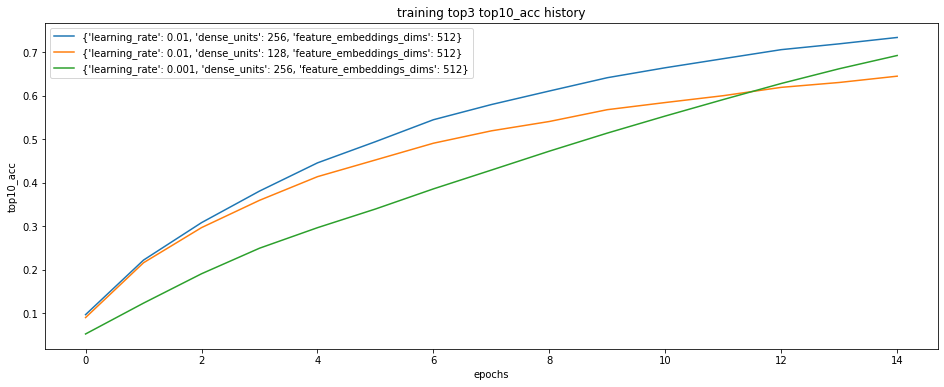

In [44]:
candidate_plot_top3('top10_acc')

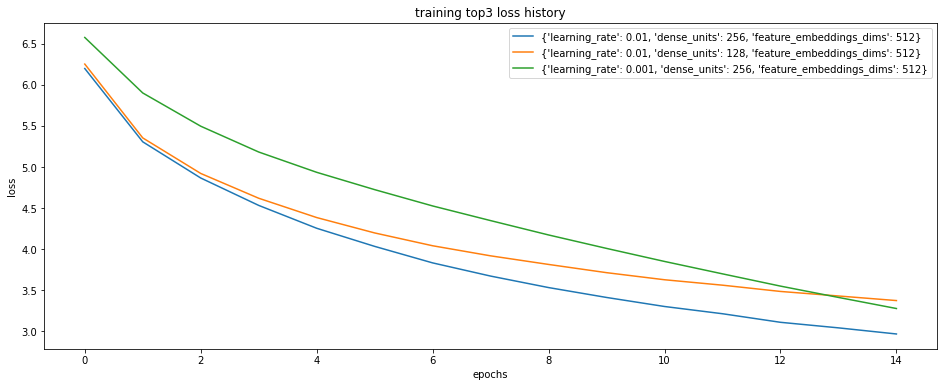

In [45]:
candidate_plot_top3('loss')

Choose best model:

In [46]:
best_model = candidate_results[candidate_results_df.val_top10_acc.nlargest(1).index.to_list()[0]]
serving_candidate_model = best_model['serving_candidate_model']
candidate_model = best_model['candidate_model']

Evaluate model:

In [47]:
X_test_candidate, y_test_candidate = get_candidate_model_data(X_test)

In [48]:
N = 10
users_candidates = serve_top_N(serving_candidate_model, N, X_test_candidate)

  0%|          | 0/16101 [00:00<?, ?it/s]

In [49]:
len(users_candidates)

16101

In [50]:
len(users_candidates[0])

10

In [51]:
c_hits_5, c_hits_10, c_mrrs_5, c_mrrs_10, c_ndcgs_5, c_ndcgs_10 = [],[],[],[],[],[]
hr_5, hr_10, mrr_5, mrr_10, ndcg_5, ndcg_10 = evaluate_model()
print(f'HR_5: {hr_5},\nHR_10: {hr_10},\nMRR_5: {mrr_5},\nMRR_10: {mrr_10},\nNDCG_5: {ndcg_5},\nNDCG_10: {ndcg_10}')

  0%|          | 0/16101 [00:00<?, ?it/s]

HR_5: 0.291,
HR_10: 0.393,
MRR_5: 0.164,
MRR_10: 0.178,
NDCG_5: 0.195,
NDCG_10: 0.229


In [52]:
candidate_metrics_update(MODEL.WIDE.name + ' (MLP BASELINE)')
candidate_metrics

,model,topk,metric,score
0,WIDE (MLP BASELINE),5,HR,0.291
1,WIDE (MLP BASELINE),10,HR,0.393
2,WIDE (MLP BASELINE),5,MRR,0.164
3,WIDE (MLP BASELINE),10,MRR,0.178
4,WIDE (MLP BASELINE),5,NDCG,0.195
5,WIDE (MLP BASELINE),10,NDCG,0.229


### Ranking

Train model:

In [53]:
X_train_ranking, y_train_ranking = get_ranking_model_data(X_train.iloc[train_idx])
X_val_ranking, y_val_ranking = get_ranking_model_data(X_train.iloc[val_idx])
ranking_results_df, ranking_results = ranking_model_train(MODEL.WIDE)



### Experiment Num 1: ###


learning_rate:0.001, dense_units:128, feature_embeddings_dims:512

Epoch 1/3
212/212 [==============================] - 19s 74ms/step - loss: 0.0291 - val_loss: 0.0059
Epoch 2/3
212/212 [==============================] - 5s 26ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 3/3
212/212 [==============================] - 4s 20ms/step - loss: 0.0020 - val_loss: 0.0024


### Experiment Num 2: ###


learning_rate:0.001, dense_units:256, feature_embeddings_dims:512

Epoch 1/3
212/212 [==============================] - 18s 72ms/step - loss: 0.0241 - val_loss: 0.0029
Epoch 2/3
212/212 [==============================] - 5s 26ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 3/3
212/212 [==============================] - 4s 16ms/step - loss: 0.0021 - val_loss: 0.0019


### Experiment Num 3: ###


learning_rate:0.01, dense_units:128, feature_embeddings_dims:512

Epoch 1/3
212/212 [==============================] - 19s 79ms/step - loss: 0.0180 - val_loss: 0.0021
Epoch 2

Focus on the top 3:

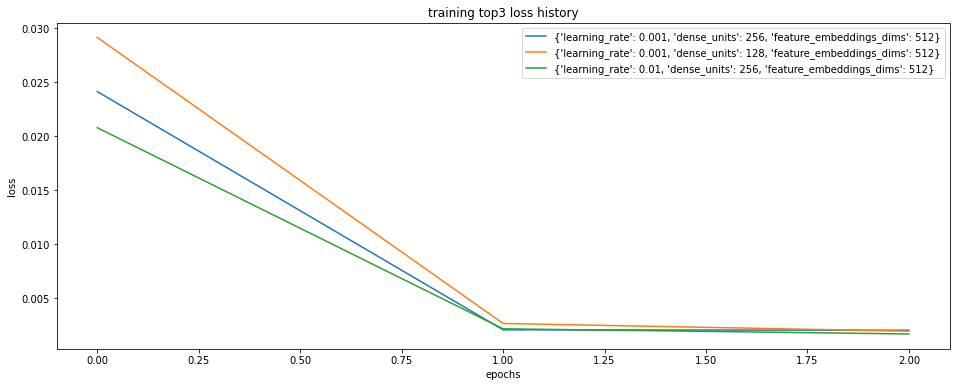

In [54]:
ranking_plot_top3('loss')

Choose best model:

In [55]:
best_model = ranking_results[ranking_results_df.val_loss.nsmallest(1).index.to_list()[0]]
serving_ranking_model = best_model['serving_ranking_model']
ranking_model = best_model['ranking_model']

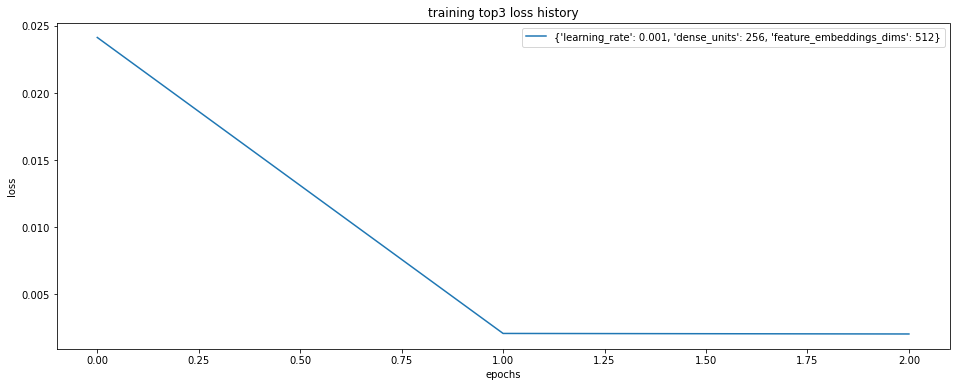

In [56]:
ranking_plot_top1('loss')

Serve Model:

In [57]:
actual_scores = []
predicted_scores = []

users_ranking = []
for candidates in tqdm(users_candidates[:500]):
    user_df = pd.DataFrame(columns=X_test.columns)
    for j, candidate in enumerate(candidates):
        user_df.at[j, :'label_genres'] = X_test.loc[j, :'label_genres']
        user_df.at[j, 'label_genres'] = movies[movies['movie_id'] == candidate]['genres'].values[0]
        user_df.at[j, 'label_age'] = movies[movies['movie_id'] == candidate]['movie_age'].values[0]
        user_df.at[j, 'label_age_sq'] = movies[movies['movie_id'] == candidate]['movie_age_sq'].values[0]
        user_df.at[j, 'label'] = candidate
        user_df.at[j, 'label_score'] = 0

    user_df['example_age'] = 0

    user_ranking_data, _ = get_ranking_model_data(user_df)

    serving_candidates_scores = serve_score(serving_ranking_model, user_ranking_data)
    users_ranking.append(np.array(candidates)[serving_candidates_scores.argsort(axis=0)[::-1].flatten()].tolist())

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluate model:

In [58]:
serving_candidates_scores

array([[13.957413 ],
       [ 3.3613539],
       [13.456045 ],
       [ 0.856019 ],
       [13.673033 ],
       [ 3.3285537],
       [13.069818 ],
       [13.515084 ],
       [13.151758 ],
       [ 3.713723 ]], dtype=float32)

In [59]:
serving_candidates_scores.argsort(axis=0)[::-1].flatten()

array([0, 4, 7, 2, 8, 6, 9, 1, 5, 3])

In [60]:
np.array(candidates)[serving_candidates_scores.argsort(axis=0)[::-1].flatten()]

array([ 77, 202, 423,  97, 157,  87,  77, 159, 216, 144])

In [61]:
users_ranking[99]

[504, 484, 479, 523, 657, 133, 484, 603, 659, 604]

In [62]:
actual_scores = []
predicted_scores = []

X_test_no_label_scores = X_test.copy()
X_test_no_label_scores['label_score']=0

y_actual_scores = np.array(X_test['label_score']).flatten()
X_test_ranking_data, _ = get_ranking_model_data(X_test_no_label_scores)
y_predicted_scores = np.array(ranking_model.predict(X_test_ranking_data,verbose=0)).flatten()
actual_scores.append(y_actual_scores)
predicted_scores.append(y_predicted_scores)

In [63]:
rmse = getRMSE(np.array(actual_scores), np.array(predicted_scores))
print(f'RMSE: {rmse}')

RMSE: 0.045


In [64]:
ranking_metrics_update(MODEL.WIDE.name + ' (MLP BASELINE)')
ranking_metrics

,model,metric,score
0,WIDE (MLP BASELINE),RMSE,0.045


## Youtube Paper Model - Deep

### Candidate

Train model:

In [65]:
X_train_candidate, y_train_candidate = get_candidate_model_data(X_train.iloc[train_idx])
X_val_candidate, y_val_candidate = get_candidate_model_data(X_train.iloc[val_idx])
candidate_results_df, candidate_results = candidate_model_train(MODEL.DEEP)



### Experiment Num 1: ###


learning_rate:0.001, dense_units:128, feature_embeddings_dims:512

Epoch 1/15
212/212 [==============================] - 19s 78ms/step - loss: 6.6226 - top5_acc: 0.0244 - top10_acc: 0.0456 - val_loss: 6.2254 - val_top5_acc: 0.0472 - val_top10_acc: 0.0841
Epoch 2/15
212/212 [==============================] - 5s 23ms/step - loss: 5.6542 - top5_acc: 0.0966 - top10_acc: 0.1639 - val_loss: 5.4631 - val_top5_acc: 0.1281 - val_top10_acc: 0.2077
Epoch 3/15
212/212 [==============================] - 4s 17ms/step - loss: 4.9729 - top5_acc: 0.1793 - top10_acc: 0.2850 - val_loss: 5.2815 - val_top5_acc: 0.1372 - val_top10_acc: 0.2237
Epoch 4/15
212/212 [==============================] - 4s 20ms/step - loss: 4.5809 - top5_acc: 0.2376 - top10_acc: 0.3617 - val_loss: 4.9032 - val_top5_acc: 0.2144 - val_top10_acc: 0.3315
Epoch 5/15
212/212 [==============================] - 3s 13ms/step - loss: 4.2656 - top5_acc: 0.2921 - top10_acc: 0.4298 - val_loss: 4.6465 - val_top5_acc

Plot training loss and accuracy, Focus on the top 3:

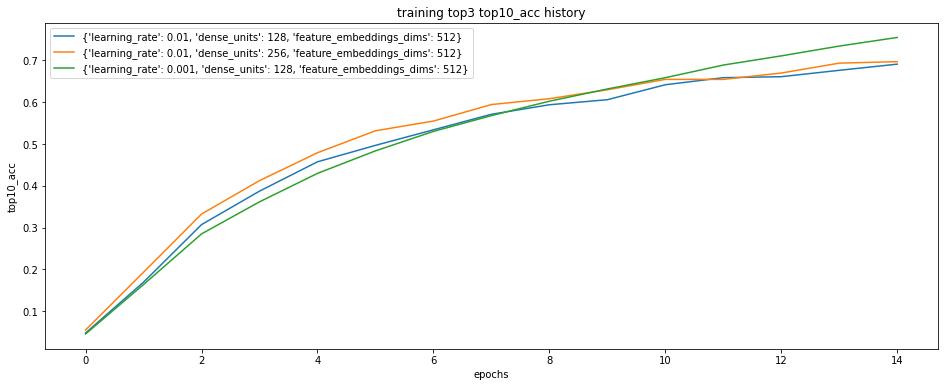

In [66]:
candidate_plot_top3('top10_acc')

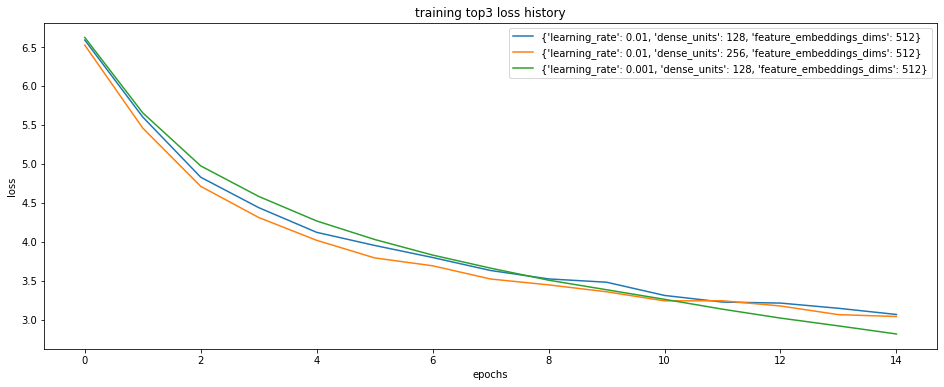

In [67]:
candidate_plot_top3('loss')

Choose best model:

In [68]:
best_model = candidate_results[candidate_results_df.val_top10_acc.nlargest(1).index.to_list()[0]]
serving_candidate_model = best_model['serving_candidate_model']
candidate_model = best_model['candidate_model']

Evaluate model:

In [69]:
X_test_candidate, y_test_candidate = get_candidate_model_data(X_test)

In [70]:
N = 10
users_candidates = serve_top_N(serving_candidate_model, N, X_test_candidate)

  0%|          | 0/16101 [00:00<?, ?it/s]

In [71]:
c_hits_5, c_hits_10, c_mrrs_5, c_mrrs_10, c_ndcgs_5, c_ndcgs_10 = [],[],[],[],[],[]
hr_5, hr_10, mrr_5, mrr_10, ndcg_5, ndcg_10 = evaluate_model()
print(f'HR_5: {hr_5},\nHR_10: {hr_10},\nMRR_5: {mrr_5},\nMRR_10: {mrr_10},\nNDCG_5: {ndcg_5},\nNDCG_10: {ndcg_10}')

  0%|          | 0/16101 [00:00<?, ?it/s]

HR_5: 0.438,
HR_10: 0.565,
MRR_5: 0.257,
MRR_10: 0.275,
NDCG_5: 0.302,
NDCG_10: 0.344


In [72]:
candidate_metrics_update(MODEL.DEEP.name + ' (YOUTUBE PAPER)')
candidate_metrics[6:]

,model,topk,metric,score
6,DEEP (YOUTUBE PAPER),5,HR,0.438
7,DEEP (YOUTUBE PAPER),10,HR,0.565
8,DEEP (YOUTUBE PAPER),5,MRR,0.257
9,DEEP (YOUTUBE PAPER),10,MRR,0.275
10,DEEP (YOUTUBE PAPER),5,NDCG,0.302
11,DEEP (YOUTUBE PAPER),10,NDCG,0.344


### Ranking

Train model:

In [73]:
X_train_ranking, y_train_ranking = get_ranking_model_data(X_train.iloc[train_idx])
X_val_ranking, y_val_ranking = get_ranking_model_data(X_train.iloc[val_idx])
ranking_results_df, ranking_results = ranking_model_train(MODEL.DEEP)



### Experiment Num 1: ###


learning_rate:0.001, dense_units:128, feature_embeddings_dims:512

Epoch 1/3
212/212 [==============================] - 20s 79ms/step - loss: 0.0108 - val_loss: 0.0027
Epoch 2/3
212/212 [==============================] - 5s 24ms/step - loss: 0.0013 - val_loss: 5.8973e-04
Epoch 3/3
212/212 [==============================] - 5s 20ms/step - loss: 2.5090e-04 - val_loss: 3.4590e-04


### Experiment Num 2: ###


learning_rate:0.001, dense_units:256, feature_embeddings_dims:512

Epoch 1/3
212/212 [==============================] - 20s 80ms/step - loss: 0.0102 - val_loss: 0.0027
Epoch 2/3
212/212 [==============================] - 5s 25ms/step - loss: 6.5089e-04 - val_loss: 2.5891e-04
Epoch 3/3
212/212 [==============================] - 4s 19ms/step - loss: 2.3325e-04 - val_loss: 9.8711e-04


### Experiment Num 3: ###


learning_rate:0.01, dense_units:128, feature_embeddings_dims:512

Epoch 1/3
212/212 [==============================] - 19s 75ms/step - loss: 0.214

Focus on the top 3:

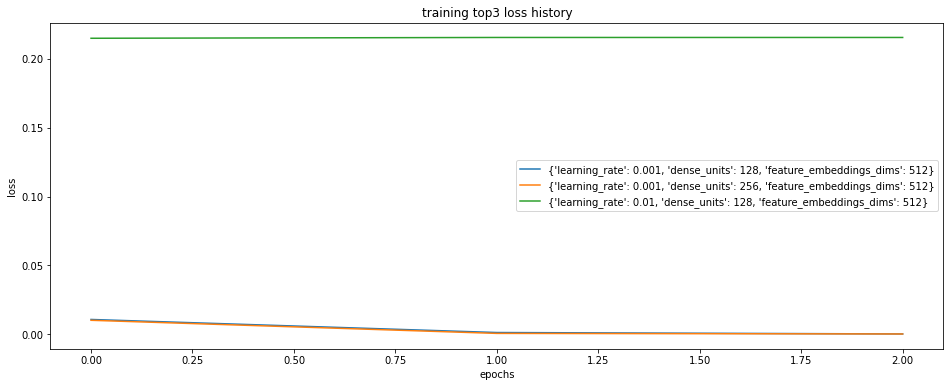

In [74]:
ranking_plot_top3('loss')

Choose best model:

In [75]:
best_model = ranking_results[ranking_results_df.val_loss.nsmallest(1).index.to_list()[0]]
serving_ranking_model = best_model['serving_ranking_model']
ranking_model = best_model['ranking_model']

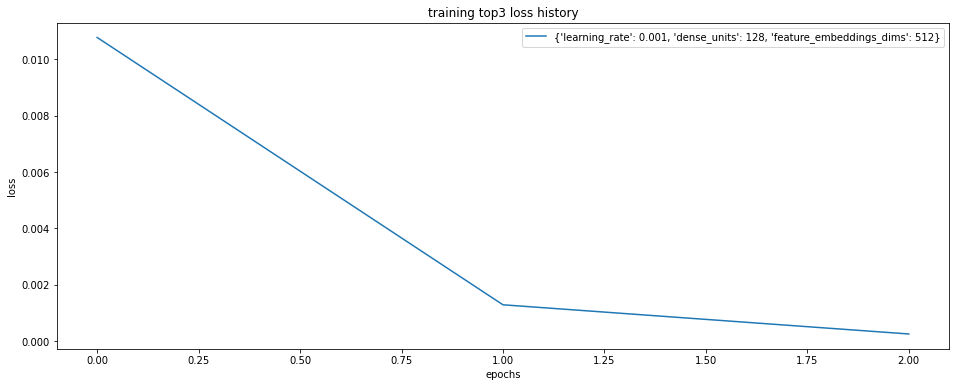

In [76]:
ranking_plot_top1('loss')

Serve Model:

In [77]:
actual_scores = []
predicted_scores = []

users_ranking = []
for candidates in tqdm(users_candidates[:500]):
    user_df = pd.DataFrame(columns=X_test.columns)
    for j, candidate in enumerate(candidates):
        user_df.at[j, :'label_genres'] = X_test.loc[j, :'label_genres']
        user_df.at[j, 'label_genres'] = movies[movies['movie_id'] == candidate]['genres'].values[0]
        user_df.at[j, 'label_age'] = movies[movies['movie_id'] == candidate]['movie_age'].values[0]
        user_df.at[j, 'label_age_sq'] = movies[movies['movie_id'] == candidate]['movie_age_sq'].values[0]
        user_df.at[j, 'label'] = candidate
        user_df.at[j, 'label_score'] = 0

    user_df['example_age'] = 0

    user_ranking_data, _ = get_ranking_model_data(user_df)

    serving_candidates_scores = serve_score(serving_ranking_model, user_ranking_data)
    users_ranking.append(np.array(candidates)[serving_candidates_scores.argsort(axis=0)[::-1].flatten()].tolist())

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluate model:

In [78]:
actual_scores = []
predicted_scores = []

X_test_no_label_scores = X_test.copy()
X_test_no_label_scores['label_score']=0

y_actual_scores = np.array(X_test['label_score']).flatten()
X_test_ranking_data, _ = get_ranking_model_data(X_test_no_label_scores)
y_predicted_scores = np.array(ranking_model.predict(X_test_ranking_data,verbose=0)).flatten()
actual_scores.append(y_actual_scores)
predicted_scores.append(y_predicted_scores)

In [79]:
rmse = getRMSE(np.array(actual_scores), np.array(predicted_scores))
print(f'RMSE: {rmse}')

RMSE: 0.018


In [80]:
ranking_metrics_update(MODEL.DEEP.name + ' (YOUTUBE PAPER)')
ranking_metrics[1:]

,model,metric,score
1,DEEP (YOUTUBE PAPER),RMSE,0.018


## Improvement Model - Wide & Deep

### Candidate

Train model:

In [81]:
X_train_candidate, y_train_candidate = get_candidate_model_data(X_train.iloc[train_idx])
X_val_candidate, y_val_candidate = get_candidate_model_data(X_train.iloc[val_idx])
candidate_results_df, candidate_results = candidate_model_train(MODEL.WIDE_AND_DEEP)



### Experiment Num 1: ###


learning_rate:0.001, dense_units:128, feature_embeddings_dims:512

Epoch 1/15
212/212 [==============================] - 19s 74ms/step - loss: 6.5786 - top5_acc: 0.0293 - top10_acc: 0.0542 - val_loss: 6.0741 - val_top5_acc: 0.0632 - val_top10_acc: 0.1112
Epoch 2/15
212/212 [==============================] - 6s 26ms/step - loss: 5.4982 - top5_acc: 0.1161 - top10_acc: 0.1933 - val_loss: 5.3682 - val_top5_acc: 0.1484 - val_top10_acc: 0.2299
Epoch 3/15
212/212 [==============================] - 4s 17ms/step - loss: 4.8811 - top5_acc: 0.1914 - top10_acc: 0.3021 - val_loss: 5.0703 - val_top5_acc: 0.1802 - val_top10_acc: 0.2862
Epoch 4/15
212/212 [==============================] - 3s 16ms/step - loss: 4.5084 - top5_acc: 0.2498 - top10_acc: 0.3776 - val_loss: 4.8433 - val_top5_acc: 0.2240 - val_top10_acc: 0.3424
Epoch 5/15
212/212 [==============================] - 3s 14ms/step - loss: 4.2155 - top5_acc: 0.3030 - top10_acc: 0.4411 - val_loss: 4.6716 - val_top5_acc

Plot training loss and accuracy, Focus on the top 3:

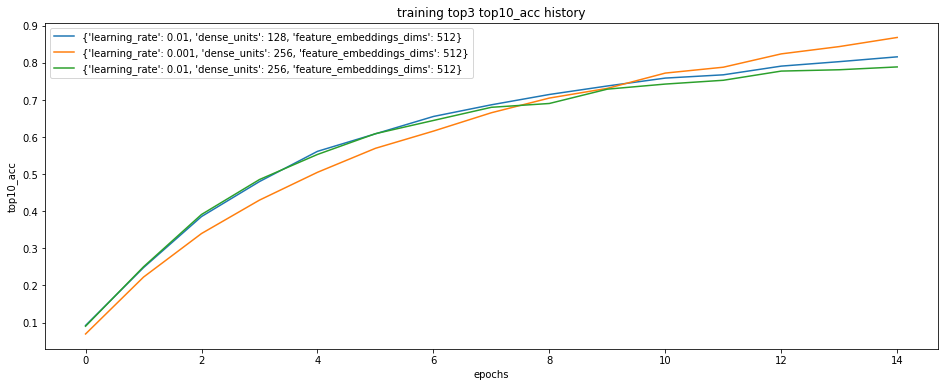

In [82]:
candidate_plot_top3('top10_acc')

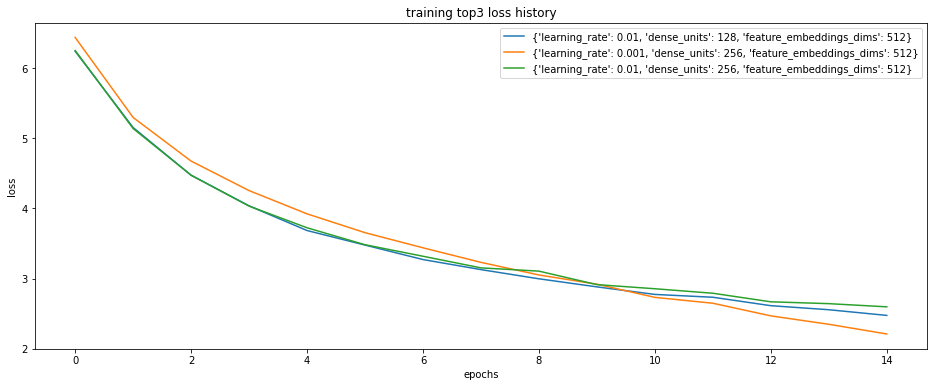

In [83]:
candidate_plot_top3('loss')

Choose best model:

In [84]:
best_model = candidate_results[candidate_results_df.val_top10_acc.nlargest(1).index.to_list()[0]]
serving_candidate_model = best_model['serving_candidate_model']
candidate_model = best_model['candidate_model']

Evaluate model:

In [85]:
X_test_candidate, y_test_candidate = get_candidate_model_data(X_test)

In [86]:
N = 10
users_candidates = serve_top_N(serving_candidate_model, N, X_test_candidate)

  0%|          | 0/16101 [00:00<?, ?it/s]

In [87]:
c_hits_5, c_hits_10, c_mrrs_5, c_mrrs_10, c_ndcgs_5, c_ndcgs_10 = [],[],[],[],[],[]
hr_5, hr_10, mrr_5, mrr_10, ndcg_5, ndcg_10 = evaluate_model()
print(f'HR_5: {hr_5},\nHR_10: {hr_10},\nMRR_5: {mrr_5},\nMRR_10: {mrr_10},\nNDCG_5: {ndcg_5},\nNDCG_10: {ndcg_10}')

  0%|          | 0/16101 [00:00<?, ?it/s]

HR_5: 0.462,
HR_10: 0.588,
MRR_5: 0.283,
MRR_10: 0.301,
NDCG_5: 0.328,
NDCG_10: 0.369


In [88]:
candidate_metrics_update(MODEL.WIDE_AND_DEEP.name + ' (IMPROVEMENT)')
candidate_metrics[12:]

,model,topk,metric,score
12,WIDE_AND_DEEP (IMPROVEMENT),5,HR,0.462
13,WIDE_AND_DEEP (IMPROVEMENT),10,HR,0.588
14,WIDE_AND_DEEP (IMPROVEMENT),5,MRR,0.283
15,WIDE_AND_DEEP (IMPROVEMENT),10,MRR,0.301
16,WIDE_AND_DEEP (IMPROVEMENT),5,NDCG,0.328
17,WIDE_AND_DEEP (IMPROVEMENT),10,NDCG,0.369


### Ranking

Train model:

In [89]:
X_train_ranking, y_train_ranking = get_ranking_model_data(X_train.iloc[train_idx])
X_val_ranking, y_val_ranking = get_ranking_model_data(X_train.iloc[val_idx])
ranking_results_df, ranking_results = ranking_model_train(MODEL.WIDE_AND_DEEP)



### Experiment Num 1: ###


learning_rate:0.001, dense_units:128, feature_embeddings_dims:512

Epoch 1/3
212/212 [==============================] - 20s 75ms/step - loss: 0.0120 - val_loss: 0.0026
Epoch 2/3
212/212 [==============================] - 6s 28ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/3
212/212 [==============================] - 4s 18ms/step - loss: 3.0990e-04 - val_loss: 2.0461e-04


### Experiment Num 2: ###


learning_rate:0.001, dense_units:256, feature_embeddings_dims:512

Epoch 1/3
212/212 [==============================] - 20s 81ms/step - loss: 0.0118 - val_loss: 0.0029
Epoch 2/3
212/212 [==============================] - 5s 26ms/step - loss: 7.0615e-04 - val_loss: 5.0853e-04
Epoch 3/3
212/212 [==============================] - 5s 22ms/step - loss: 2.4822e-04 - val_loss: 0.0022


### Experiment Num 3: ###


learning_rate:0.01, dense_units:128, feature_embeddings_dims:512

Epoch 1/3
212/212 [==============================] - 19s 74ms/step - loss: 0.2150 - val_

Focus on the top 3:

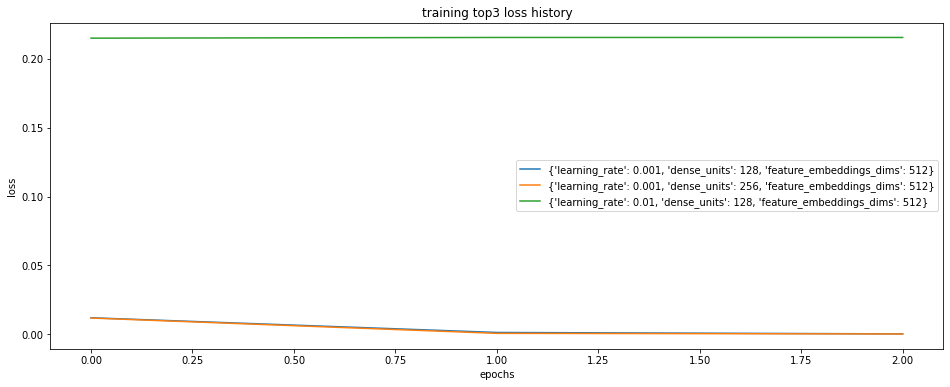

In [90]:
ranking_plot_top3('loss')

Choose best model:

In [91]:
best_model = ranking_results[ranking_results_df.val_loss.nsmallest(1).index.to_list()[0]]
serving_ranking_model = best_model['serving_ranking_model']
ranking_model = best_model['ranking_model']

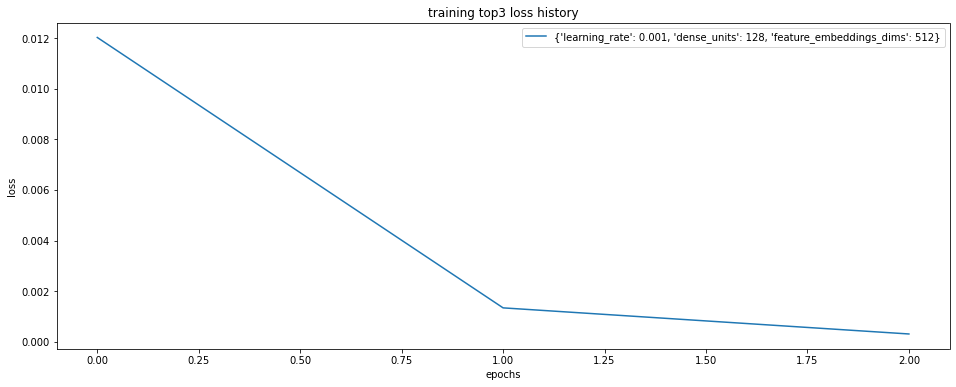

In [92]:
ranking_plot_top1('loss')

Serve Model:

In [93]:
actual_scores = []
predicted_scores = []

users_ranking = []
for candidates in tqdm(users_candidates[:500]):
    user_df = pd.DataFrame(columns=X_test.columns)
    for j, candidate in enumerate(candidates):
        user_df.at[j, :'label_genres'] = X_test.loc[j, :'label_genres']
        user_df.at[j, 'label_genres'] = movies[movies['movie_id'] == candidate]['genres'].values[0]
        user_df.at[j, 'label_age'] = movies[movies['movie_id'] == candidate]['movie_age'].values[0]
        user_df.at[j, 'label_age_sq'] = movies[movies['movie_id'] == candidate]['movie_age_sq'].values[0]
        user_df.at[j, 'label'] = candidate
        user_df.at[j, 'label_score'] = 0

    user_df['example_age'] = 0

    user_ranking_data, _ = get_ranking_model_data(user_df)
   
    serving_candidates_scores = serve_score(serving_ranking_model, user_ranking_data)
    users_ranking.append(np.array(candidates)[serving_candidates_scores.argsort(axis=0)[::-1].flatten()].tolist())

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluate model:

In [94]:
actual_scores = []
predicted_scores = []

X_test_no_label_scores = X_test.copy()
X_test_no_label_scores['label_score']=0

y_actual_scores = np.array(X_test['label_score']).flatten()
X_test_ranking_data, _ = get_ranking_model_data(X_test_no_label_scores)
y_predicted_scores = np.array(ranking_model.predict(X_test_ranking_data,verbose=0)).flatten()
actual_scores.append(y_actual_scores)
predicted_scores.append(y_predicted_scores)

In [95]:
rmse = getRMSE(np.array(actual_scores), np.array(predicted_scores))
print(f'RMSE: {rmse}')

RMSE: 0.014


In [96]:
ranking_metrics_update(MODEL.WIDE_AND_DEEP.name + ' (IMPROVEMENT)')
ranking_metrics[2:]

,model,metric,score
2,WIDE_AND_DEEP (IMPROVEMENT),RMSE,0.014


# Results

All Results:

In [97]:
candidate_metrics

,model,topk,metric,score
0,WIDE (MLP BASELINE),5,HR,0.291
1,WIDE (MLP BASELINE),10,HR,0.393
2,WIDE (MLP BASELINE),5,MRR,0.164
3,WIDE (MLP BASELINE),10,MRR,0.178
4,WIDE (MLP BASELINE),5,NDCG,0.195
5,WIDE (MLP BASELINE),10,NDCG,0.229
6,DEEP (YOUTUBE PAPER),5,HR,0.438
7,DEEP (YOUTUBE PAPER),10,HR,0.565
8,DEEP (YOUTUBE PAPER),5,MRR,0.257
9,DEEP (YOUTUBE PAPER),10,MRR,0.275


In [98]:
ranking_metrics

,model,metric,score
0,WIDE (MLP BASELINE),RMSE,0.045
1,DEEP (YOUTUBE PAPER),RMSE,0.018
2,WIDE_AND_DEEP (IMPROVEMENT),RMSE,0.014


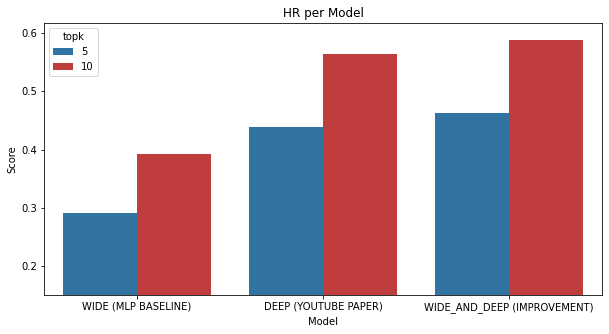

In [99]:
plot_candidate_metrics('HR')

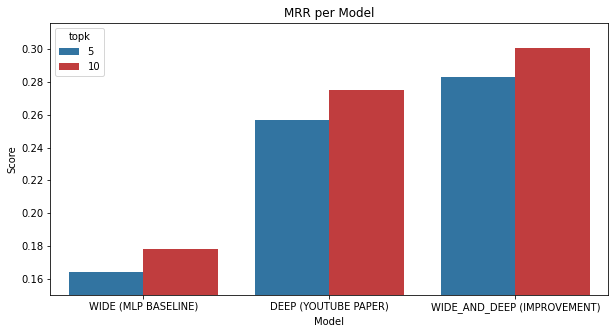

In [100]:
plot_candidate_metrics('MRR')

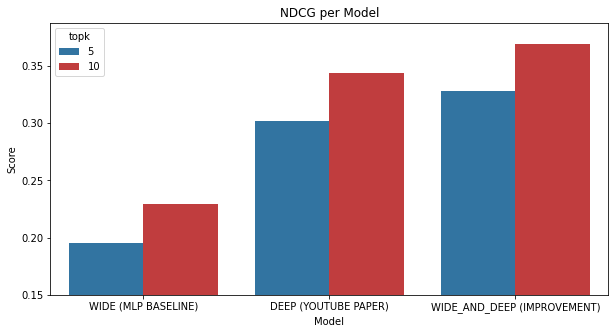

In [101]:
plot_candidate_metrics('NDCG')

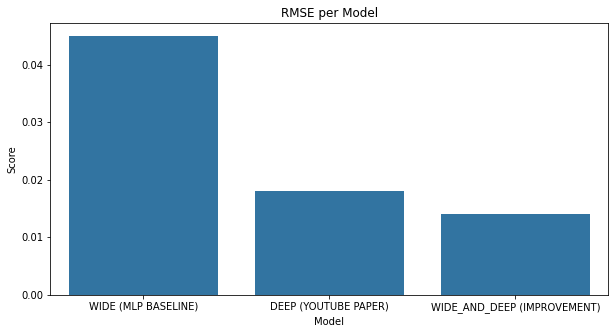

In [102]:
plot_ranking_metrics('RMSE')